# Analyzing outliers from data & Returning Dates

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np
import os
import time
from itertools import chain


##### ETF Data Clean up ###########

class ETFDataCleanup(object):
    
    def __init__(self):
        pass

    def showNaColumns(self,df):
        s=df.isnull().sum()
        print(s[s>0])
    
    def dropNAColumns(self,df):
        return df.dropna(axis='columns')
    
    def computeDailyReturns(self,df):
        return df.pct_change().dropna()        
    
    
####### Get Data for Constituents of ETF

class ConstituentsData(ETFDataCleanup):
    
    def __init__(self,fileName=None,startdate=None,enddate=None):
        self.fileName=fileName
        self.startdate=startdate
        self.enddate=enddate
        self.constituentdata=[]
        self.constituentcloseDF=[]
        self.tickerdf=[]
        self.changeDF=[]
        self.waDF=[]
    
    def getconstituentdata(self):
        self.tickerdf = pd.read_excel(self.fileName)
        tickers=self.tickerdf['Ticker']
        self.tickerdf.set_index('Ticker',inplace=True)
        self.constituentdata =  web.DataReader(tickers,'yahoo',self.startdate,self.enddate)
        self.constituentcloseDF = self.constituentdata['Close'].iloc[:, :]
        
    def stringWeightsToFloat(self):
        self.tickerdf['Weights']=self.tickerdf['Weights'].apply(lambda x: x.replace('%','')).astype(float)
    
    def findNetAssetValue(self):
        self.waDF=self.changeDF
        for col in self.changeDF.columns:
            # Divide by 100 for weights percentage eg 23.28%
            self.waDF[col]=self.changeDF[col]*self.tickerdf['Weights'].loc[col]/100
        self.waDF['NAV']=self.waDF.sum(axis=1)

####### Get prices of ETF        
class ETFStockPrices(ETFDataCleanup):
    
    def __init__(self,etfticker=None,startdate=None,enddate=None):
        self.etfticker=etfticker
        self.startdate=startdate
        self.enddate=enddate
        self.etfdata=[]
        self.etfchangeDF=[]

        
    def getETFTickerData(self):
        self.etfdata =  web.DataReader(self.etfticker,'yahoo',self.startdate,self.enddate)
 


class ETFArbitrage(object):

    def __init__(self,etfob,waDF):
        self.navDF=pd.merge(etfob,waDF['NAV'],left_index=True,right_index=True)
        self.navDF['Date']=self.navDF.index
        self.navDF['Close']=self.navDF['Close']*100
        self.navDF['NAV']=self.navDF['NAV']*100
        del self.navDF['Date']
    
    def scatterplot(self):
        plt.scatter(self.navDF['Close'],self.navDF['NAV'])
        
    def scatterplot2(self):
        #change figure size for the plot
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0]=12
        fig_size[1]=6
        plt.rcParams["figure.figsize"]=fig_size

        self.navDF['Mispricing']=(self.navDF['Close']-self.navDF['NAV'])
        plt.scatter(self.navDF.index,self.navDF['Mispricing'])
    
    def seaborndist(self):
        sns.distplot(self.navDF['Mispricing'].values, hist=True, kde=True, 
             bins='auto', color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

# Load any ETF you want

XLK
Tickers with NA Values
Symbols
NLOK    64
dtype: int64
***************
Check for NA Values again
Series([], dtype: int64)
***************
Data for Constituents
Symbols         AAPL       ACN      ADBE       ADI       ADP           ADS  \
Date                                                                         
2019-01-03 -0.019971 -0.000696 -0.001031 -0.000387 -0.000356 -1.770502e-05   
2019-01-04  0.008559  0.000793  0.001269  0.000155  0.000470  4.737537e-05   
2019-01-07 -0.000446  0.000071  0.000354  0.000040 -0.000064 -4.326626e-08   
2019-01-08  0.003822  0.000516  0.000389  0.000156  0.000070  1.216524e-05   
2019-01-09  0.003405  0.000103  0.000308  0.000162  0.000011  1.531917e-05   

Symbols         ADSK      AKAM      AMAT       AMD  ...       TEL       TXN  \
Date                                                ...                       
2019-01-03 -0.000369 -0.000053 -0.000493 -0.000804  ... -0.000187 -0.001079   
2019-01-04  0.000354  0.000070  0.000582  0.000972  

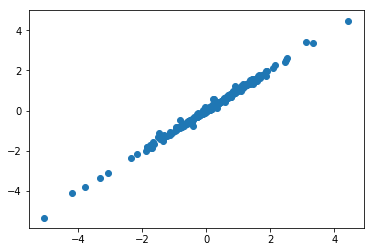

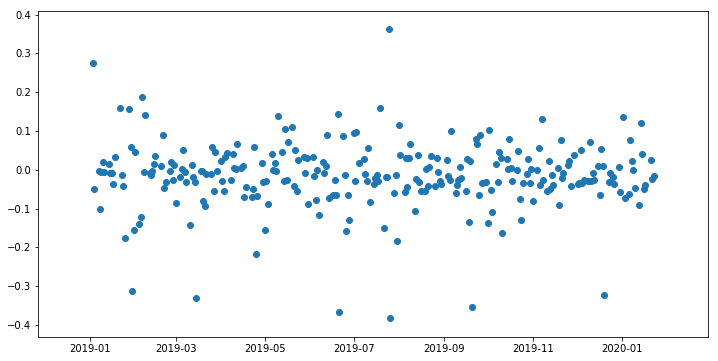

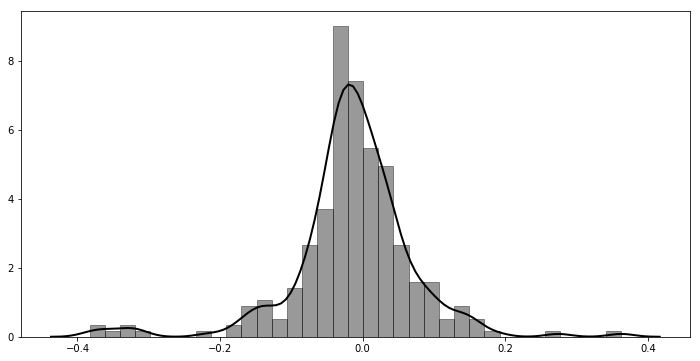

In [2]:
tickeretf="XLK"

filename='ETFDailyData'+'/'+dt.datetime.now().strftime("%Y%m%d")+'/'+tickeretf+'.xls'
startdate=dt.datetime(2019,1,1)
enddate=dt.datetime(2020,1,22)

ob=ConstituentsData(fileName=filename,startdate=startdate,enddate=enddate)
ob.getconstituentdata()
print(tickeretf)
print("Tickers with NA Values")
ob.showNaColumns(ob.constituentcloseDF)
ob.constituentcloseDF=ob.dropNAColumns(ob.constituentcloseDF)
print("***************")
print("Check for NA Values again")
ob.showNaColumns(ob.constituentcloseDF)
ob.changeDF=ob.computeDailyReturns(ob.constituentcloseDF)
ob.stringWeightsToFloat()
ob.findNetAssetValue()

print("***************")
print("Data for Constituents")
print(ob.waDF.head(5))

etfob=ETFStockPrices(etfticker=tickeretf,startdate=dt.datetime(2019,1,1),enddate=dt.datetime(2020,1,22))
etfob.getETFTickerData()
print("Show Any Empty Values")
etfob.showNaColumns(etfob.etfdata)
etfob.etfchangeDF=etfob.computeDailyReturns(etfob.etfdata['Close'])

print("***************")
print("Data for ETF stock prices")
print(etfob.etfchangeDF.head(5))

print("****************")
print("Charts")
arbob=ETFArbitrage(etfob.etfchangeDF,ob.waDF)
arbob.scatterplot()
plt.show()
arbob.scatterplot2()
plt.show()
arbob.seaborndist()
plt.show()

# List down all objects of 3 different classes

In [3]:
print("Constituents Data Objects")
print(dir(ob))

print("*************************")
print("ETF Price Object")
print(dir(etfob))

print("*************************")
print("Arbitrage Data Object")
print(dir(arbob))

Constituents Data Objects
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'changeDF', 'computeDailyReturns', 'constituentcloseDF', 'constituentdata', 'dropNAColumns', 'enddate', 'fileName', 'findNetAssetValue', 'getconstituentdata', 'showNaColumns', 'startdate', 'stringWeightsToFloat', 'tickerdf', 'waDF']
*************************
ETF Price Object
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute

In [4]:
print(arbob.navDF.head(5))

               Close       NAV  Mispricing
Date                                      
2019-01-03 -5.046761 -5.321237    0.274476
2019-01-04  4.431993  4.481555   -0.049562
2019-01-07  0.894308  0.896754   -0.002446
2019-01-08  0.838035  0.939619   -0.101585
2019-01-09  1.294552  1.300313   -0.005761


## Z-Score Method

In [5]:
tempChangeDf=ob.changeDF*100
del tempChangeDf['NAV']
tempChangeDf=round(tempChangeDf,4)

In [6]:
# Calculate Z-Score for the Mispricing Column
arbob.navDF['Z-Score'] = np.abs(stats.zscore(arbob.navDF['Mispricing']))

In [7]:
negmovers=[]
posmovers=[]

for col in tempChangeDf.T:
    values=(tempChangeDf.T[col].sort_values())
    negmovers.append(dict(values[:3]))
    posmovers.append(dict(values[(len(values)-3):]))

    
arbob.navDF['Top negmovers']=negmovers
arbob.navDF['Top posmovers']=posmovers    

In [9]:
arbob.navDF

,Close,NAV,Mispricing,Z-Score,negmovers,posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.321237,0.274476,3.354135,"{'AAPL': -1.9971, 'MSFT': -0.7074, 'INTC': -0....","{'XRX': -0.0022, 'ADS': -0.0018, 'DXC': 0.0005}"
2019-01-04,4.431993,4.481555,-0.049562,0.413679,"{'FTNT': -0.0024, 'WU': 0.0023, 'ANET': 0.0029}","{'INTC': 0.2724, 'AAPL': 0.8559, 'MSFT': 0.8944}"
2019-01-07,0.894308,0.896754,-0.002446,0.134169,"{'AAPL': -0.0446, 'ADP': -0.0064, 'QCOM': -0.0...","{'CRM': 0.0769, 'V': 0.0967, 'NVDA': 0.1207}"
2019-01-08,0.838035,0.939619,-0.101585,1.018579,"{'NVDA': -0.0568, 'AMAT': -0.0344, 'AVGO': -0....","{'CRM': 0.0613, 'MSFT': 0.1394, 'AAPL': 0.3822}"
2019-01-09,1.294552,1.300313,-0.005761,0.095631,"{'AMD': -0.0229, 'CSCO': -0.0172, 'MSI': -0.0132}","{'AVGO': 0.0822, 'MSFT': 0.275, 'AAPL': 0.3405}"
2019-01-10,0.441778,0.422957,0.018821,0.381458,"{'MSFT': -0.1236, 'AMD': -0.0189, 'CSCO': -0.0...","{'NVDA': 0.0424, 'INTC': 0.0509, 'AAPL': 0.0641}"
2019-01-11,-0.188500,-0.182683,-0.005816,0.094983,"{'AAPL': -0.1969, 'MSFT': -0.1485, 'V': -0.0236}","{'AMD': 0.0228, 'INTC': 0.0338, 'NVDA': 0.0565}"
2019-01-14,-0.928549,-0.943766,0.015216,0.339544,"{'AAPL': -0.3015, 'MSFT': -0.1403, 'INTC': -0....","{'FIS': 0.0018, 'AVGO': 0.0023, 'NVDA': 0.0247}"
2019-01-15,1.509135,1.518416,-0.009281,0.054697,"{'QCOM': -0.0422, 'MU': -0.0186, 'NVDA': -0.0086}","{'ADBE': 0.0868, 'AAPL': 0.4104, 'MSFT': 0.5578}"


# Show me days with Arbitrage Opportunities

In [10]:
daysofarbitrage=arbob.navDF[arbob.navDF['Z-Score']>3]

In [11]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score,negmovers,posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.321237,0.274476,3.354135,"{'AAPL': -1.9971, 'MSFT': -0.7074, 'INTC': -0....","{'XRX': -0.0022, 'ADS': -0.0018, 'DXC': 0.0005}"
2019-01-30,3.108003,3.419620,-0.311617,3.460766,"{'JNPR': -0.0099, 'MXIM': -0.0024, 'GLW': -0.002}","{'AMD': 0.1696, 'MSFT': 0.6426, 'AAPL': 1.3701}"
2019-03-15,0.884588,1.215490,-0.330902,3.685002,"{'ADBE': -0.1034, 'ORCL': -0.0037, 'FTNT': -0....","{'AVGO': 0.1565, 'MSFT': 0.2215, 'AAPL': 0.2608}"
2019-06-21,-0.823204,-0.456529,-0.366675,4.100959,"{'AAPL': -0.0684, 'PYPL': -0.0456, 'MA': -0.0378}","{'ADSK': 0.0057, 'ADI': 0.0063, 'INTC': 0.0254}"
2019-07-25,-0.410872,-0.773469,0.362597,4.378776,"{'AAPL': -0.1585, 'PYPL': -0.107, 'MSFT': -0.0...","{'GPN': 0.0193, 'FISV': 0.0247, 'FIS': 0.0254}"
2019-07-26,0.218411,0.601401,-0.382989,4.290662,"{'INTC': -0.0485, 'XLNX': -0.0203, 'ADSK': -0....","{'FISV': 0.0653, 'AAPL': 0.0697, 'MSFT': 0.1577}"
2019-09-20,-1.473112,-1.118556,-0.354556,3.960044,"{'AAPL': -0.2931, 'MSFT': -0.2222, 'MA': -0.0747}","{'NOW': 0.0081, 'CRM': 0.0259, 'CSCO': 0.0261}"
2019-12-20,0.253523,0.577088,-0.323565,3.599694,"{'AAPL': -0.0415, 'AVGO': -0.0299, 'CSCO': -0....","{'V': 0.042, 'INTC': 0.0758, 'MSFT': 0.2099}"
